In [1]:
import numpy as np
from bokeh.plotting import figure, show, output_file, gridplot
from scipy.spatial.transform import Rotation as R
from bokeh.layouts import row
from scipy.signal import filtfilt, sosfilt, medfilt, butter, lfilter
import matplotlib.pyplot as plt
import math
from ahrs.filters import Complementary, Madgwick, EKF, Tilt, AQUA, QUEST
import glob

def gravitational_filter(acc_data, fs):
    """
    Function to filter out the gravitational component of ACC signals using a 3rd order butterworth lowpass filter with
    a cuttoff frequency of 0.3 Hz
    The implementation is based on: https://www.elen.ucl.ac.be/Proceedings/esann/esannpdf/es2013-84.pdf

    :param acc_data: a 1-D or (MxN) array, where where M is the signal length in samples and
                 N is the number of signals / channels.
    :param fs: the sampling frequency of the acc data.
    :return: the gravitational component of each signal/channel contained in acc_data
    """

    # define the filter
    order = 3
    f_c = 1
    filt = butter(order, f_c, fs=fs, output='sos')

    # copy the array
    gravity_data = acc_data.copy()

    # check the dimensionality of the input
    if gravity_data.ndim > 1: # (MxN) array

        # cycle of the channels contained in data
        for channel in range(gravity_data.shape[1]):

            # get the channel
            sig = acc_data[:, channel]

            # apply butterworth filter
            gravity_data[:, channel] = sosfilt(filt, sig)

    else: # 1-D array

        gravity_data = sosfilt(filt, acc_data)

    return gravity_data



def inertial_data_filter(acc_data, fs, medfilt_window_length=11):
    """
    function to filter the accelerometer data. First a median filter is applied and then a 3rd order butterworth lowpass
    filter with a cutoff frequency of 20 Hz is applied.
    The filtering scheme is based on:
    https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=8567275
    :param acc_data: a 1-D or (MxN) array, where where M is the signal length in samples and
                 N is the number of signals / channels.
    :param fs: the sampling frequency of the acc data.
    :param medfilt_window_length: the length of the median filter. Has to be odd.
    :return: the filtered data
    """

    # define the filter
    order = 1
    f_c = 10
    b, a = butter(order, f_c, fs=fs, output='ba')

    # copy the array
    filtered_data = acc_data.copy()

    # check the dimensionality of the input
    if filtered_data.ndim > 1:  # (MxN) array

        # cycle of the channels contained in data
        for channel in range(filtered_data.shape[1]):
            # get the channel
            sig = acc_data[:, channel]

            # apply the median filter
            #sig = medfilt(sig, medfilt_window_length)

            # apply butterworth filter
            #filtered_data[:, channel] = sosfilt(filt, sig)
            filtered_data[:, channel] = filtfilt(b, a, sig)

    else:  # 1-D array

        # apply median filter
        #med_filt = medfilt(acc_data, medfilt_window_length)

        # apply butterworth filter
        #filtered_data = sosfilt(filt, med_filt)
        filtered_data = filtfilt(b, a, med_filt)

    return filtered_data

def smooth(y, win_size):
    
    # copy the array
    smooth_data = y.copy()
    window = np.ones(win_size)/win_size
    
    # check the dimensionality of the input
    if smooth_data.ndim > 1:  # (MxN) array
    
        # cycle of the channels contained in data
        for channel in range(smooth_data.shape[1]):
            smooth_data[:, channel] = np.convolve(y[:, channel], window, mode='same')
            
    else:
        smooth_data = np.convolve(y, window, mode='same')
    
    return smooth_data

def quaternation_to_euler_angles(signal, Mode = False):

    orientation_angles = signal.copy()
    # cycle of the rows contained in data
    for row in range(signal.shape[0]):
        if Mode == False:
            x = signal[row,0]
            y = signal[row,1]
            z = signal[row,2]
            w = signal[row,3]
            
        x = signal[row,1]
        y = signal[row,2]
        z = signal[row,3]
        w = signal[row,0]

        ysqr = y * y

        t0 = +2.0 * (w * x + y * z)
        t1 = +1.0 - 2.0 * (x * x + ysqr)
        X = math.degrees(math.atan2(t0, t1))-90

        t2 = +2.0 * (w * y - z * x)
        t2 = +1.0 if t2 > +1.0 else t2 # singularities from euler angles
        t2 = -1.0 if t2 < -1.0 else t2 # singularities from euler angles
        Y = math.degrees(math.asin(t2))

        t3 = +2.0 * (w * z + x * y)
        t4 = +1.0 - 2.0 * (ysqr + z * z)
        Z = math.degrees(math.atan2(t3, t4))


        orientation_angles[row,0] = X
        orientation_angles[row,1] = Y
        orientation_angles[row,2] = Z

    return orientation_angles

def q_conjugate(q):
    w, x, y, z = tuple(q)
    return (w, -x, -y, -z)

def qv_mult(q1, v1):
    q2 = (0.0,) + v1
    return q_mult(q_mult(q1, q2), q_conjugate(q1))

def q_mult(q1, q2):
    w1, x1, y1, z1 = tuple(q1)
    w2, x2, y2, z2 = tuple(q2)
    w = w1 * w2 - x1 * x2 - y1 * y2 - z1 * z2
    x = w1 * x2 + x1 * w2 + y1 * z2 - z1 * y2
    y = w1 * y2 + y1 * w2 + z1 * x2 - x1 * z2
    z = w1 * z2 + z1 * w2 + x1 * y2 - y1 * x2
    return w, x, y, z

def calculate_normalized_data(signal):
    
    data_normalized = signal.copy()
    # cycle of the rows contained in data
    for row in range(signal.shape[0]):
        x = signal[row,0]
        y = signal[row,1]
        z = signal[row,2]
        
        norm = math.sqrt((x*x)+(y*y)+(z*z))
        
        x = signal[row,0]/norm
        y = signal[row,1]/norm
        z = signal[row,2]/norm
        
        data_normalized[row,:] = np.array([x,y,z])
          
    
    return data_normalized



'''
def rotmat_from_quaternion(Q):
   
    x,  y , z, w = tuple(Q)
    row1 = [1 - 2*y*y - 2*z*z , 2*x*y - 2*w*z , 2*x*z + 2*w*y]
    row2 = [2*x*y + 2*w*z, 1 - 2*x*x - 2*z*z , 2*y*z - 2*w*x]
    row3 = [2*x*z - 2*w*y , 2*y*z + 2*w*x , 1 - 2*x*x - 2*y*y]
    
    return np.matrix([row1, row2, row3])
    


# Checks if a matrix is a valid rotation matrix.
def isRotationMatrix(R) :

    Rt = np.transpose(R)
    shouldBeIdentity = np.dot(Rt, R)
    I = np.identity(3, dtype = R.dtype)
    n = np.linalg.norm(I - shouldBeIdentity)
    print(n)

    
    return n < 1e-6

# Calculates rotation matrix to euler angles
# The result is the same as MATLAB except the order
# of the euler angles ( x and z are swapped ).

def euler_from_rotmat(R) :

    assert(isRotationMatrix(R))
    sy = math.sqrt(R[0,0] * R[0,0] +  R[1,0] * R[1,0])
    singular = sy < 1e-6
 
    if  not singular :
        x = math.atan2(R[2,1] , R[2,2])
        y = math.atan2(-R[2,0], sy)
        z = math.atan2(R[1,0], R[0,0])
    else :
        x = math.atan2(-R[1,2], R[1,1])
        y = math.atan2(-R[2,0], sy)
        z = 0

    return np.array([x, y, z])

'''

'\ndef rotmat_from_quaternion(Q):\n   \n    x,  y , z, w = tuple(Q)\n    row1 = [1 - 2*y*y - 2*z*z , 2*x*y - 2*w*z , 2*x*z + 2*w*y]\n    row2 = [2*x*y + 2*w*z, 1 - 2*x*x - 2*z*z , 2*y*z - 2*w*x]\n    row3 = [2*x*z - 2*w*y , 2*y*z + 2*w*x , 1 - 2*x*x - 2*y*y]\n    \n    return np.matrix([row1, row2, row3])\n    \n\n\n# Checks if a matrix is a valid rotation matrix.\ndef isRotationMatrix(R) :\n\n    Rt = np.transpose(R)\n    shouldBeIdentity = np.dot(Rt, R)\n    I = np.identity(3, dtype = R.dtype)\n    n = np.linalg.norm(I - shouldBeIdentity)\n    print(n)\n\n    \n    return n < 1e-6\n\n# Calculates rotation matrix to euler angles\n# The result is the same as MATLAB except the order\n# of the euler angles ( x and z are swapped ).\n\ndef euler_from_rotmat(R) :\n\n    assert(isRotationMatrix(R))\n    sy = math.sqrt(R[0,0] * R[0,0] +  R[1,0] * R[1,0])\n    singular = sy < 1e-6\n \n    if  not singular :\n        x = math.atan2(R[2,1] , R[2,2])\n        y = math.atan2(-R[2,0], sy)\n        

In [2]:
#file = '/Users/sarasilva/Desktop/android_synchronised.txt'
file = '/Users/sarasilva/Desktop/Thesis_Acquisitions/Synchronised_DATA/android_wear_biosignalsPLUX_sync/BB_new_android_bitalino_sync.txt'
# reads the data from the file and converts it into numpy.array.
data = np.loadtxt(file)
    
# stores the data of that sensor in a variable assigned to each sensor.
acc_phone = data[13000:,1:4]
gyr_phone = data[13000:,4:7]
mag_phone = data[13000:,7:10]*(1e-3)
#mag_phone = data[:,11:]
rotation_vector_data = data[13000:,11:15]
#rotation_vector_data = data[:,7:11]


#application of filters for signal pre-processing
    
acc_phone = inertial_data_filter(acc_phone,100)
#acc_phone = calculate_normalized_data(acc_phone)
gyr_phone = inertial_data_filter(gyr_phone,100)
gyr_phone = smooth(gyr_phone, 100)
#gyr_phone = calculate_normalized_data(gyr_phone)
mag_phone = inertial_data_filter(mag_phone,100)
#mag_phone = calculate_normalized_data(mag_phone)


tilt = Tilt(acc=acc_phone, mag=mag_phone, as_angles=True)
#aqua = AQUA(gyr=gyr_phone, acc=acc_phone,mag = mag_phone, frequency = 20, frame='ENU', threshold = 0.98)
complementary = Complementary(gyr = gyr_phone, acc = acc_phone, mag = mag_phone, gain=0.02, q0 = [1,0,0,0])
madgwick = Madgwick(gyr=gyr_phone, acc=acc_phone,mag = mag_phone, q0 = [1,0,0,0])
#quest = QUEST(acc=acc_phone, mag=mag_phone)
#ekf = EKF(gyr=gyr_phone, acc=acc_phone, mag = mag_phone, frequency = 20, frame='ENU')


orientation_from_cf = quaternation_to_euler_angles(complementary.Q, Mode = True)
#orientation_from_ekf = quaternation_to_euler_angles(ekf.Q, Mode = True)
#r1 = R.from_quat(complementary.Q)
#orientation_from_cf = r1.as_euler('xyz')
orientation_from_mf = quaternation_to_euler_angles(madgwick.Q, Mode = True)
#orientation_from_am = quaternation_to_euler_angles(aqua.Q, Mode = True)

#r2 = R.from_quat(madgwick.Q)
#orientation_from_mf = r2.as_euler('xyz', degrees = True)
#orientation_from_rv = quaternation_to_euler_angles(rotation_vector_data)
r3 = R.from_quat(rotation_vector_data)
#orientation_from_rv = quaternation_to_euler_angles(rotation_vector_data)
orientation_from_rv = r3.as_euler('xyz', degrees = True)

'''
orientation_from_rv = []
for line in range(rotation_vector_data.shape[0]):
    #x, y, z = euler_from_rotmat(rotmat_from_quaternion(rotation_vector_data[line]))
    #orientation_from_rv.append(euler_from_rotmat(rotmat_from_quaternion(rotation_vector_data[line])))
    r = R.from_quat([rotation_vector_data[line]])
    orientation_from_rv.append(r.as_euler('xyz'))

orientation_from_rv = np.vstack((orientation_from_rv))
    


fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(18,8))
ax1.plot(data[:,0], complementary.Q)
ax2.plot(data[:,0], madgwick.Q)
ax3.plot(data[:,0], rotation_vector_data)
plt.show()

'''

F = figure(x_axis_label='Time (s)', y_axis_label='ANGLE (degrees)')
F.line(data[13000:, 0], orientation_from_cf[:,0], legend_label='Pitch', line_color='darkseagreen')
F.line(data[13000:, 0], orientation_from_cf[:,1], legend_label='Yaw', line_color='orange')
F.line(data[13000:, 0], orientation_from_cf[:,2], legend_label='Roll', line_color='darksalmon')
G = figure(x_axis_label='Time (s)', y_axis_label='ANGLE (degrees)')
G.line(data[13000:, 0], orientation_from_mf[:,0], legend_label='Pitch', line_color='darkseagreen')
G.line(data[13000:, 0], orientation_from_mf[:,1], legend_label='Yaw', line_color='orange')
G.line(data[13000:, 0], orientation_from_mf[:,2], legend_label='Roll', line_color='darksalmon')
H = figure(x_axis_label='Time (s)', y_axis_label='ANGLE (degrees)')
H.line(data[13000:, 0], orientation_from_rv[:,0], legend_label='Pitch', line_color='darkseagreen')
H.line(data[13000:, 0], orientation_from_rv[:,1], legend_label='Yaw', line_color='orange')
H.line(data[13000:, 0], orientation_from_rv[:,2], legend_label='Roll', line_color='darksalmon')

show(row(F,G,H))    
   
 

In [3]:
import numpy as np

age = [49,34,20,22,29,30,32,24,23,23,28,20]

mean = np.mean(age)
print(mean)
std = np.std(age)
print(std)

27.833333333333332
7.787097590815778


In [4]:
height = [170,181,163,170,181,171,173,168,159,157,156,162]

mean1 = np.mean(height)
print(mean1)
std1 = np.std(height)
print(std1)


167.58333333333334
8.087627725249364


In [5]:
weight = [55,80,47,55,70,60,72,55,57,55,54,52]
mean2 = np.mean(weight)
print(mean2)
std2 = np.std(weight)
print(std2)

59.333333333333336
9.204467514322717


In [6]:
import glob
import pandas as pd
import numpy as np
emg_time = []

for file in glob.glob('/Users/sarasilva/Desktop/Thesis_Acquisitions/Synchronised_DATA/PLUX_converted/*'):
    df_plux = pd.read_csv(file, skiprows=3, sep='\t', names=["nSeq", "DI", "rEMG", "lEMG", "xAcc", "yAcc", "zAcc"],
                          index_col=False)
    e_time = df_plux["nSeq"].iloc[-1]
    emg_time.append(e_time)
        
j = -1
acquisitionTime = 0
time = []

for folder in glob.glob('/Users/sarasilva/Desktop/Thesis_Acquisitions/Original_DATA/*'):
    j += 1
    for file in glob.glob(folder + '/*'):
        if 'ANDROID' in file:
            pass
        elif 'WEAR' in file:
            pass
        else:
            acquisitionTime = emg_time[j]
            time.append(acquisitionTime)

print(time)
mean = np.mean(time)
print(mean)
std=np.std(time)
print(std)

[3575.817, 3594.677, 3591.049, 3579.007, 3586.143, 3596.529, 3594.395, 3573.329, 3582.848, 3594.093, 3590.112, 3596.548]
3587.878916666667
7.940012022013655


In [7]:
import numpy as np
print(np.std([1880.858412,1564.452324,1629.881978,1823.241254,1708.006938,2012.694282,2026.36615,1898.436528,1903.319338,1727.538178,2253.905096,1863.280296]))


180.78319659250718


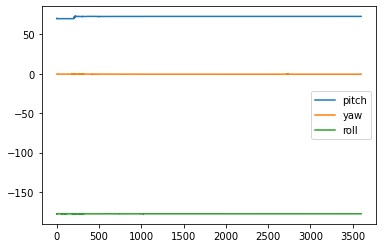

In [2]:
import biosignalsnotebooks as bsnb
# set file path (this file path needs to be set accoridng to where you saved the data)
file_path="/Users/sarasilva/Desktop/opensignals_ANDROID_ROTATION_VECTOR_2021-10-18_16-28-00.txt"

# load the data from the file
data = np.loadtxt(file_path)

time_inter, data_inter, sampling_rate_inter = bsnb.re_sample_data(data[:,0], data[:,1:], sampling_rate = 100, shift_time_axis=True)

orientation_from_rotation = quaternation_to_euler_angles(data_inter)

plt.plot(time_inter, orientation_from_rotation[:,0], label = 'pitch')
plt.plot(time_inter, orientation_from_rotation[:,1], label = 'yaw')
plt.plot(time_inter, orientation_from_rotation[:,2], label = 'roll')
plt.legend()
plt.show()

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import math
def getRotationMatrixFromVector(rotation_vector):
    
    orientation_angles = rotation_vector.copy()
    
    # cycle of the rows contained in data
    for row in range(rotation_vector.shape[0]):
        
        R = np.zeros((3,3))
        q0 = rotation_vector[row,3];
        q1 = rotation_vector[row,0];
        q2 = rotation_vector[row,1];
        q3 = rotation_vector[row,2];



        sq_q1 = 2 * q1 * q1;
        sq_q2 = 2 * q2 * q2;
        sq_q3 = 2 * q3 * q3;
        q1_q2 = 2 * q1 * q2;
        q3_q0 = 2 * q3 * q0;
        q1_q3 = 2 * q1 * q3;
        q2_q0 = 2 * q2 * q0;
        q2_q3 = 2 * q2 * q3;
        q1_q0 = 2 * q1 * q0;

        
        R[0][0] = 1 - sq_q2 - sq_q3;
        R[0][1] = q1_q2 - q3_q0;
        R[0][2] = q1_q3 + q2_q0;

        R[1][0] = q1_q2 + q3_q0;
        R[1][1] = 1 - sq_q1 - sq_q3;
        R[1][2] = q2_q3 - q1_q0;

        R[2][0] = q1_q3 - q2_q0;
        R[2][1] = q2_q3 + q1_q0;
        R[2][2] = 1 - sq_q1 - sq_q2;
        
        
        X = math.degrees(math.atan2(R[0][1], R[1][1]));
        Y = math.degrees(math.asin(-R[2][1]));
        Z = math.degrees(math.atan2(-R[2][0], R[2][2]));
        
        orientation_angles[row,0] = X
        orientation_angles[row,1] = Y
        orientation_angles[row,2] = Z
        
    return orientation_angles


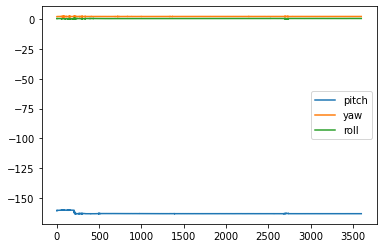

In [4]:
orientation_from_rotation = getRotationMatrixFromVector(data_inter)
plt.plot(time_inter, orientation_from_rotation[:,0], label = 'pitch')
plt.plot(time_inter, orientation_from_rotation[:,1], label = 'yaw')
plt.plot(time_inter, orientation_from_rotation[:,2], label = 'roll')
plt.legend()
plt.show()